## Import Library

In [4]:
# Import libraries
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

## Mount Google Drive
Mengakses Dataset

In [5]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pemisahan Dataset dan Augmentasi Data



In [8]:
# Lokasi Dataset
train_dir = '/content/drive/MyDrive/PI/train'
val_dir = '/content/drive/MyDrive/PI/valid'
test_dir = '/content/drive/MyDrive/PI/test'

# Generator untuk data pelatihan dengan augmentasi
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    shear_range=0.2,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Generator untuk data validasi dan uji tanpa augmentasi
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Data pelatihan
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=True,
    class_mode='binary'
)

# Data validasi
val_data = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

Found 1538 images belonging to 2 classes.
Found 440 images belonging to 2 classes.


## Visualisasi Dataset
Menampilkan beberapa gambar dari dataset untuk melihat hasil augmentasi :

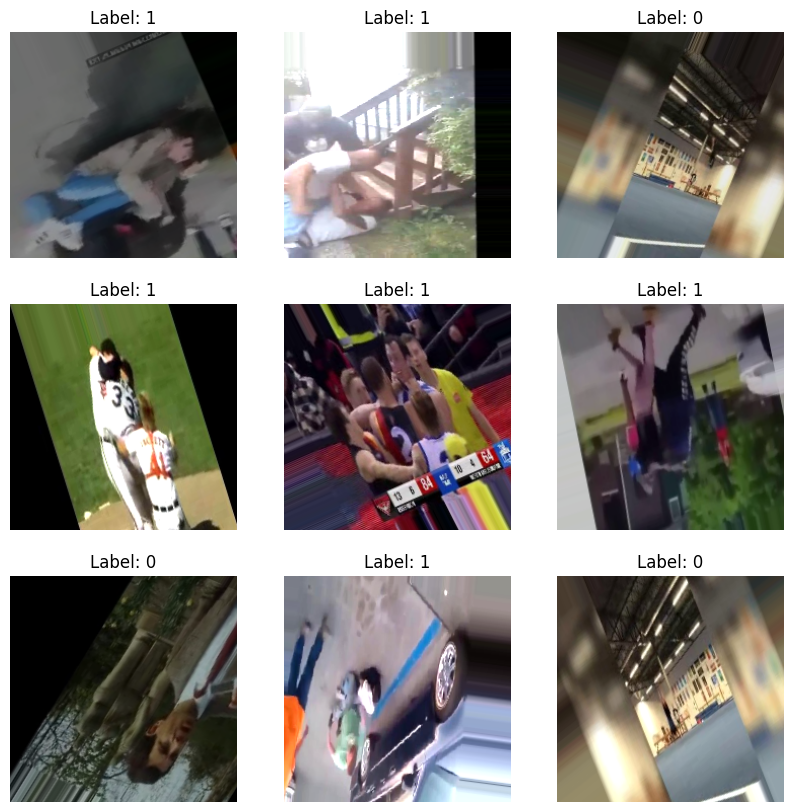

In [9]:
# Visualisasi data pelatihan
def visualize_data(data):
    images, labels = next(data)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i])
        plt.title(f"Label: {int(labels[i])}")
        plt.axis('off')
    plt.show()

visualize_data(train_data)

## Membangun Model
Menggunakan model VGG16 yang telah dilatih sebelumnya dengan modifikasi :

In [10]:
# Load VGG16 pre-trained model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze 20
for layer in base_model.layers[:20]:
    layer.trainable = False
for layer in base_model.layers[20:]:
    layer.trainable = True

# Build the model
model = models.Sequential([
    base_model,  # Menambahkan VGG16
    layers.GlobalAveragePooling2D(),  # Pooling layer
    # First fully connected layer
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    # Second fully connected layer
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

checkpoint = ModelCheckpoint(
    'NoMCLAHE_Freeze20_0.001.h5',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,112,001 (57.65 MB)

 Trainable params: 395,777 (1.51 MB)

 Non-trainable params: 14,716,224 (56.14 MB)

## Melatih Model
Melakukan pelatihan model dengan data pelatihan dan validasi:

In [11]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6527 - loss: 1.2414
Epoch 1: val_accuracy improved from -inf to 0.74091, saving model to NoMCLAHE_Freeze20_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 555s 11s/step - accuracy: 0.6536 - loss: 1.2388 - val_accuracy: 0.7409 - val_loss: 0.9296
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 618ms/step - accuracy: 0.7696 - loss: 0.9092
Epoch 2: val_accuracy improved from 0.74091 to 0.82045, saving model to NoMCLAHE_Freeze20_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 673ms/step - accuracy: 0.7695 - loss: 0.9089 - val_accuracy: 0.8205 - val_loss: 0.8439
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.7895 - loss: 0.7804
Epoch 3: val_accuracy did not improve from 0.82045
49/49 ━━━━━━━━━━━━━━━━━━━━ 40s 658ms/step - accuracy: 0.7895 - loss: 0.7806 - val_accuracy: 0.6205 - val_loss: 0.8703
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.7919 - loss: 0.7901
Epoch 4: val_accuracy did not improve from 0.82045
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 686ms/step - accuracy: 0.7918 - loss: 0.7898 - val_accuracy: 0.7114 - val_loss: 0.8133
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.8164 - loss: 0.7513
Epoch 5: val_accuracy did not improve from 0.82045
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 659ms/step - accuracy: 0.8164 - loss: 0.7511 - val_accuracy: 0.7841 - val_loss: 0.7271
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 608ms/step - accuracy: 0.8048 - loss: 0.6969
Epoch 6: val_accuracy did not i

49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 664ms/step - accuracy: 0.8241 - loss: 0.6673 - val_accuracy: 0.8750 - val_loss: 0.5849
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 627ms/step - accuracy: 0.8185 - loss: 0.6679
Epoch 8: val_accuracy did not improve from 0.87500
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 683ms/step - accuracy: 0.8186 - loss: 0.6678 - val_accuracy: 0.8591 - val_loss: 0.5894
Epoch 9/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.8205 - loss: 0.6328
Epoch 9: val_accuracy improved from 0.87500 to 0.88409, saving model to NoMCLAHE_Freeze20_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 665ms/step - accuracy: 0.8206 - loss: 0.6329 - val_accuracy: 0.8841 - val_loss: 0.5364
Epoch 10/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.8310 - loss: 0.6531
Epoch 10: val_accuracy improved from 0.88409 to 0.88864, saving model to NoMCLAHE_Freeze20_0.001.h5


49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 662ms/step - accuracy: 0.8308 - loss: 0.6531 - val_accuracy: 0.8886 - val_loss: 0.5282
Epoch 11/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.8413 - loss: 0.6169
Epoch 11: val_accuracy did not improve from 0.88864
49/49 ━━━━━━━━━━━━━━━━━━━━ 34s 684ms/step - accuracy: 0.8413 - loss: 0.6168 - val_accuracy: 0.8545 - val_loss: 0.5458
Epoch 12/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 605ms/step - accuracy: 0.8029 - loss: 0.6631
Epoch 12: val_accuracy did not improve from 0.88864
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 656ms/step - accuracy: 0.8033 - loss: 0.6623 - val_accuracy: 0.8591 - val_loss: 0.5218
Epoch 13/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.8530 - loss: 0.5913
Epoch 13: val_accuracy did not improve from 0.88864
49/49 ━━━━━━━━━━━━━━━━━━━━ 35s 717ms/step - accuracy: 0.8528 - loss: 0.5915 - val_accuracy: 0.8636 - val_loss: 0.5441
Epoch 14/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.8553 - loss: 0.5744
Epoch 14: val_accuracy d

49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 664ms/step - accuracy: 0.8586 - loss: 0.5201 - val_accuracy: 0.8955 - val_loss: 0.4405
Epoch 26/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.8526 - loss: 0.5276
Epoch 26: val_accuracy did not improve from 0.89545
49/49 ━━━━━━━━━━━━━━━━━━━━ 41s 662ms/step - accuracy: 0.8524 - loss: 0.5275 - val_accuracy: 0.8455 - val_loss: 0.5298
Epoch 27/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.8361 - loss: 0.5172
Epoch 27: val_accuracy did not improve from 0.89545
49/49 ━━━━━━━━━━━━━━━━━━━━ 33s 672ms/step - accuracy: 0.8365 - loss: 0.5170 - val_accuracy: 0.8818 - val_loss: 0.4256
Epoch 28/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.8436 - loss: 0.5288
Epoch 28: val_accuracy did not improve from 0.89545
49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 657ms/step - accuracy: 0.8439 - loss: 0.5285 - val_accuracy: 0.8818 - val_loss: 0.4765
Epoch 29/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 630ms/step - accuracy: 0.8493 - loss: 0.5094
Epoch 29: val_accuracy d

## Visualisasi Akurasi dan Loss
Menampilkan grafik akurasi dan loss selama pelatihan:

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.9189 - loss: 0.3109
Validation Loss: 0.41935789585113525
Validation Accuracy: 0.8795454502105713


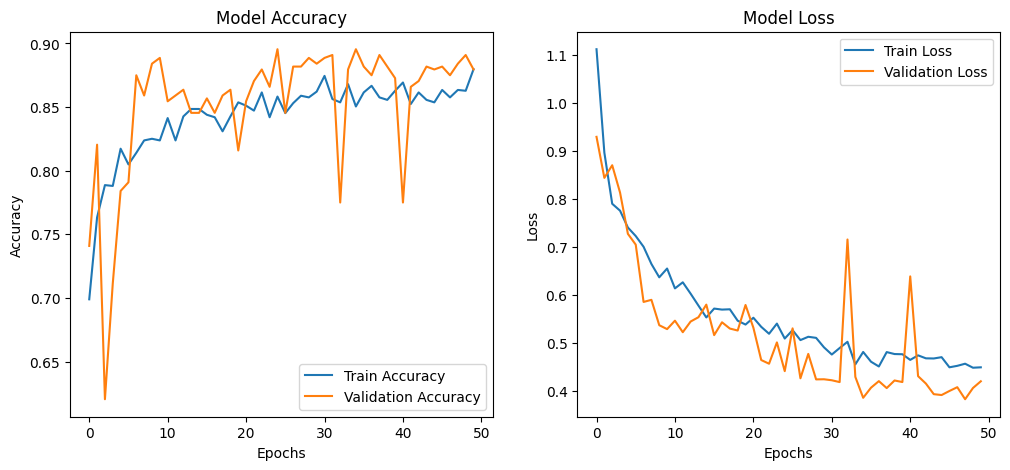

In [12]:
# 2. Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

# Plot training and validation metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

In [13]:
# Data uji
test_data = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    color_mode='rgb',
    shuffle=False,
    class_mode='binary'
)

# Muat model dengan val_accuracy tertinggi
best_model = load_model('NoMCLAHE_Freeze20_0.001.h5')

# Evaluasi pada test set
test_loss, test_acc = best_model.evaluate(test_data, verbose=1)
print("Test Accuracy : {:.2f}%".format(test_acc * 100))
print("Test Loss     : {:.3f}".format(test_loss))

Found 222 images belonging to 2 classes.


7/7 ━━━━━━━━━━━━━━━━━━━━ 55s 9s/step - accuracy: 0.8731 - loss: 0.4298
Test Accuracy : 89.64%
Test Loss     : 0.412


## Evaluasi Model
Menghitung confusion matrix dan tampilkan classification report:

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 265ms/step


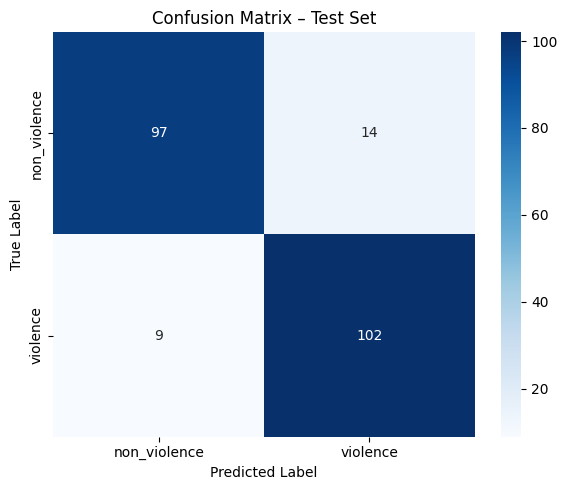


Classification Report (Test Set):
              precision    recall  f1-score   support

non_violence       0.92      0.87      0.89       111
    violence       0.88      0.92      0.90       111

    accuracy                           0.90       222
   macro avg       0.90      0.90      0.90       222
weighted avg       0.90      0.90      0.90       222



In [14]:
# -------------------------------------------------------------
# 1) Buat prediksi pada TEST SET dengan model terbaik
# -------------------------------------------------------------
test_pred_prob   = best_model.predict(test_data, verbose=1)  # ← ganti 'model' → 'best_model'
test_pred_labels = (test_pred_prob > 0.5).astype("int32").flatten()

# -------------------------------------------------------------
# 2) Label asli dan nama kelas
# -------------------------------------------------------------
true_test_labels = test_data.classes
class_names      = list(test_data.class_indices.keys())

# -------------------------------------------------------------
# 3) Confusion Matrix
# -------------------------------------------------------------
cm = confusion_matrix(true_test_labels, test_pred_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix – Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 4) Classification Report
# -------------------------------------------------------------
print("\nClassification Report (Test Set):")
print(classification_report(true_test_labels,
                            test_pred_labels,
                            target_names=class_names,
                            digits=2))